# 2D MLG sanity checks

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
sys.path.append("../src")

In [24]:
from hamiltonians import *
from tb import *
from utils import check_pt_in_lst, check_lst_in_lst, check_lsts_equal
from geometry import MLGGeom
from plot import make_patch_function, get_shifted_brillouin_zone_path

## First sanity check: does $\langle\chi_k\vert H\vert\chi_k\rangle$ produce the same eigenvalues as the analytically known form of the Hamiltonian

In [25]:
geom = MLGGeom(d=1)
Ncells = (4, 4)
N = np.prod(Ncells)
ks = get_kpt_mesh(Ncells, geom.b.T, shift=None)
H, basis, T = mlg_hamiltonian(Ncells, geom.a, t=1)
T = T.reshape((N, -1))
chik = get_bloch_wavefunction(ks, T, basis)
Hk = np.einsum("kim,ij,kjn->kmn", chik.conj(), H, chik)
evals = np.linalg.eigvalsh(Hk)

Hk2 = mlg_k_hamiltonian(ks, t=1, deltas=geom.deltas)
evals2 = np.linalg.eigvalsh(Hk2)

np.allclose(evals, evals2)

True

# Second sanity check: dirac points

In [26]:
geom = MLGGeom(d=1)
ks = get_kpt_mesh((1,1), geom.b.T, shift=geom.k1)
Hk2 = mlg_k_hamiltonian(ks, t=1, deltas=geom.deltas)
print(np.linalg.eigvalsh(Hk2))

[[-8.67111902e-16  8.67111902e-16]]


# Now, no truncation, just change basis and plot

In [27]:
geom = MLGGeom(d=1)
Ncells = (12, 12)
N = np.prod(Ncells)
ks = get_kpt_mesh(Ncells, geom.b.T, shift=None)

H, basis, T = mlg_hamiltonian(Ncells, geom.a, t=1)
T = T.reshape(N, 2)

chik = get_bloch_wavefunction(ks, T, basis)
Hk = np.einsum("kim,ij,kjn->kmn", chik.conj(), H, chik)
evals = np.linalg.eigvalsh(Hk)
ediff = np.diff(evals, axis=1).squeeze()
vmin, vmax = np.min(ediff), np.max(ediff)

H = H.reshape((np.prod(Ncells)*2, np.prod(Ncells)*2))
Px = get_momentum_operator(chik, ks[:,0])
Py = get_momentum_operator(chik, ks[:,1])

Text(0.5, 1.0, 'Band structure monolayer graphene')

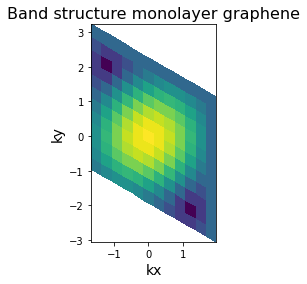

In [28]:
plt.gca().set_aspect(1.)
plt.pcolormesh(ks[:,0].reshape(Ncells),
               ks[:,1].reshape(Ncells),
               ediff.reshape(Ncells))

plt.xlabel("kx", fontsize=14)
plt.ylabel("ky", fontsize=14)
plt.title("Band structure monolayer graphene", fontsize=16)
# plt.savefig("img/bs_mlg.png", dpi=150)

In [29]:
Nblocks = (1, 1)
Ncluster_cells = (Ncells[0] // Nblocks[0], Ncells[1] // Nblocks[1])

hcluster_pp, b1, T1 = mlg_hamiltonian(Ncluster_cells, geom.a, t=1, bc=[1,1])
hcluster_ap, b2, T2 = mlg_hamiltonian(Ncluster_cells, geom.a, t=1, bc=[1,-1])
hcluster_pa, b3, T3 = mlg_hamiltonian(Ncluster_cells, geom.a, t=1, bc=[-1,1])
hcluster_aa, b4, T4 = mlg_hamiltonian(Ncluster_cells, geom.a, t=1, bc=[-1,-1])

ea, ua = np.linalg.eigh(hcluster_pp)
eb, ub = np.linalg.eigh(hcluster_ap)
ec, uc = np.linalg.eigh(hcluster_pa)
ed, ud = np.linalg.eigh(hcluster_aa)

ecutoff = 1.1

ua = ua[:, np.abs(ea) < ecutoff]
ub = ub[:, np.abs(eb) < ecutoff]
uc = uc[:, np.abs(ec) < ecutoff]
ud = ud[:, np.abs(ed) < ecutoff]

u = np.concatenate([ua, ub, uc, ud], axis=1)
q, r = np.linalg.qr(u)

U = get_block_transformation_matrix(q, np.prod(Nblocks))

print(U.shape)

(288, 288)


In [30]:
kr, er, Vp = basis_transform_and_relabel(H, [Px, Py], U, Norb=2)
ediff2 = np.diff(er, axis=1).squeeze()
ediff2 = np.abs(ediff2) # Hard to keep track of order of energy eigenstates

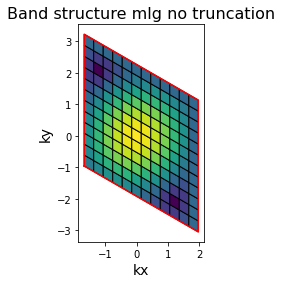

In [31]:
cmap = matplotlib.cm.get_cmap("viridis")
make_patch = make_patch_function(geom.b, Ncells, cmap, vmin=vmin, vmax=vmax)

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
bz = get_shifted_brillouin_zone_path(geom.b, Ncells)

for i in range(len(kr)):
    p = make_patch(kr[i], ediff2[i])
    ax.add_patch(p)
plt.plot(bz.T[0], bz.T[1], c='r')


plt.xlabel("kx", fontsize=14)
plt.ylabel("ky", fontsize=14)
plt.title("Band structure mlg no truncation", fontsize=16)
plt.savefig("img/bs_mlg_no_trunc.png", dpi=150)

# Now, let's do truncation

In [53]:
def get_filename(ecutoff, Ncells, truncation, **params):
    fname = f"ecut{ecutoff}_Ncells_{Ncells[0]}x{Ncells[1]}_trunc{truncation}"
    for k in params:
        fname += f"_{k}{params[k]}"
    return fname

In [158]:
geom = MLGGeom(d=1)
ks = get_kpt_mesh((24, 24), geom.b.T, shift=None)
Hk = mlg_k_hamiltonian(ks, t=1., deltas=geom.deltas)

evals = np.linalg.eigvalsh(Hk)
ediff = np.diff(evals, axis=1).squeeze()

In [154]:
geom = MLGGeom(d=1)
Ncells = (24, 24)
N = np.prod(Ncells)
ks = get_kpt_mesh(Ncells, geom.b.T, shift=None)

H, basis, T = mlg_hamiltonian(Ncells, geom.a, t=1)
T = T.reshape(N, 2)

chik = get_bloch_wavefunction(ks, T, basis)
# Hk = np.einsum("kim,ij,kjn->kmn", chik.conj(), H, chik)
# evals = np.linalg.eigvalsh(Hk)
# ediff = np.diff(evals, axis=1).squeeze()

H = H.reshape((np.prod(Ncells)*2, np.prod(Ncells)*2))
Px = get_momentum_operator(chik, ks[:,0])
Py = get_momentum_operator(chik, ks[:,1])

In [164]:
Nblocks = (1, 1)
Nbc = 4
ecutoff = .8
Ncluster_cells = (Ncells[0] // Nblocks[0], Ncells[1] // Nblocks[1])

hcluster_pp, b1, T1 = mlg_hamiltonian(Ncluster_cells, geom.a, t=1, bc=[1,1])
hcluster_ap, b2, T2 = mlg_hamiltonian(Ncluster_cells, geom.a, t=1, bc=[1,-1])
hcluster_pa, b3, T3 = mlg_hamiltonian(Ncluster_cells, geom.a, t=1, bc=[-1,1])
hcluster_aa, b4, T4 = mlg_hamiltonian(Ncluster_cells, geom.a, t=1, bc=[-1,-1])

ea, ua = np.linalg.eigh(hcluster_pp)
eb, ub = np.linalg.eigh(hcluster_ap)
ec, uc = np.linalg.eigh(hcluster_pa)
ed, ud = np.linalg.eigh(hcluster_aa)

ua = ua[:, np.abs(ea) < ecutoff]
ub = ub[:, np.abs(eb) < ecutoff]
uc = uc[:, np.abs(ec) < ecutoff]
ud = ud[:, np.abs(ed) < ecutoff]

if Nbc == 1:
    u = np.concatenate([ua], axis=1)
elif Nbc == 2:
    u = np.concatenate([ua, ud], axis=1)
elif Nbc == 4:
    u = np.concatenate([ua, ub, uc, ud], axis=1)
    
q, r = np.linalg.qr(u)

U = get_block_transformation_matrix(q, np.prod(Nblocks))
print(U.shape)
kr = basis_transform_and_relabel(H, [Px, Py], U, Norb=2)
kr, er, Vp = basis_transform_and_relabel(H, [Px, Py], U, Norb=2)
ediff2 = np.diff(er, axis=1).squeeze()
ediff2 = np.abs(ediff2)

(1152, 640)


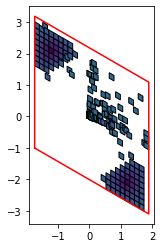

In [165]:
cmap = matplotlib.cm.get_cmap("viridis")
fname = get_filename(ecutoff, Ncells, U.shape[-1], bc=Nbc)
make_patch = make_patch_function(geom.b, Ncells, cmap, vmin=vmin, vmax=vmax)

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
bz = get_shifted_brillouin_zone_path(geom.b, Ncells)

for i in range(len(ediff2)):
    p = make_patch(kr[i], ediff2[i])
    ax.add_patch(p)
plt.plot(bz.T[0], bz.T[1], c='r')

# plt.xlabel("kx", fontsize=14)
# plt.ylabel("ky", fontsize=14)
# plt.title(f"BS MLG trunc={U.shape[0]}->{U.shape[-1]},\n Ncells={Ncells}, ecut={ecutoff}, bc={Nbc}", fontsize=14)
# plt.tight_layout()
# plt.savefig(f"img/{fname}.png", dpi=150)

(array([ 55.,  42.,  66.,  48.,  72.,  84., 105.,  66.,  24.,  14.,  14.,
         24.,  66., 105.,  84.,  72.,  48.,  66.,  42.,  55.]),
 array([-3. , -2.7, -2.4, -2.1, -1.8, -1.5, -1.2, -0.9, -0.6, -0.3,  0. ,
         0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <BarContainer object of 20 artists>)

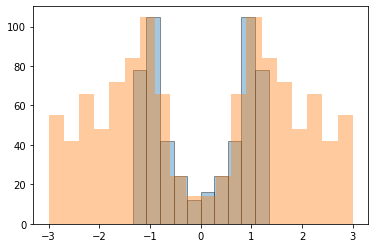

In [163]:
plt.hist(er.ravel(), bins=10, alpha=.4, edgecolor="black");
plt.hist(evals.ravel(), bins=20, alpha=.4)

(array([ 55.,  42.,  66.,  48.,  72.,  84., 105.,  66.,  24.,  14.,  14.,
         24.,  66., 105.,  84.,  72.,  48.,  66.,  42.,  55.]),
 array([-3. , -2.7, -2.4, -2.1, -1.8, -1.5, -1.2, -0.9, -0.6, -0.3,  0. ,
         0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <BarContainer object of 20 artists>)

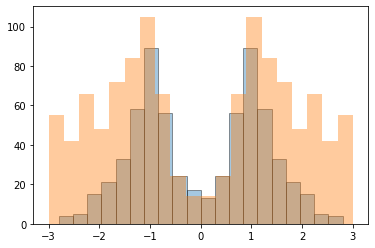

In [166]:
plt.hist(er.ravel(), bins=20, alpha=.4, edgecolor="black");
plt.hist(evals.ravel(), bins=20, alpha=.4)